# **Capture Network Traffic**
- Wireshark was used to capture and save network traffic in .pcap format.
- The file was then loaded using tshark and the outputs saved into a CSV file.

# **Load the Network Data**
Loads network traffic data from a CSV file (network_traffic.csv) into a Pandas DataFrame (df). The data includes columns such as frame_no, time, src (source IP), dst (destination IP), len (packet length), and ip_protocol (IP protocol used).



In [ ]:
import pandas as pd
import hashlib

# Load the CSV file into a DataFrame
df = pd.read_csv('network_traffic.csv', names=['frame_no', 'time', 'src', 'dst', 'len', 'ip_protocol'], delimiter='\t')

# **Anonymization of IP Addresses**
- To enhance privacy and security, IP addresses were anonymized in the DataFrame by applying SHA-256 hashing. Anonymization ensures that sensitive information (IP addresses) cannot be directly linked back to individuals or specific machines.

In [ ]:
# Anonymize IP addresses
def anonymize_ip(ip):
    if pd.isna(ip):
        return ip
    return hashlib.sha256(ip.encode()).hexdigest()

# Apply anonymization
df['src'] = df['src'].apply(anonymize_ip)
df['dst'] = df['dst'].apply(anonymize_ip)

# Set frame_no to index
df.set_index('frame_no', inplace= True)

# Display the first few rows of the DataFrame
df.head()


,time,src,dst,len,ip_protocol
frame_no,,,,,
1,"Jun 1, 2024 08:44:32.193086270 EDT",4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,07b6f543852baba02810e5110929c9cb16a52549b2d8e2...,93,6.0
2,"Jun 1, 2024 08:44:32.193461370 EDT",07b6f543852baba02810e5110929c9cb16a52549b2d8e2...,4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,60,6.0
3,"Jun 1, 2024 08:44:32.193838616 EDT",4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,e96cdb99dc6513c971275f89bc57f114435f95a3fc272e...,93,6.0
4,"Jun 1, 2024 08:44:32.194258602 EDT",e96cdb99dc6513c971275f89bc57f114435f95a3fc272e...,4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,60,6.0
5,"Jun 1, 2024 08:44:32.200081288 EDT",07b6f543852baba02810e5110929c9cb16a52549b2d8e2...,4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,93,6.0


# **Preprocessing the Data**
Handle missing values, normalize the data, and preparing it for clustering,
- Any row with missing values are removed to ensure a clean data.
- The len (packet length) and ip_protocol columns are normalized using StandardScaler to have a mean of 0 and a standard deviation of 1. This normalization step is essential for clustering algorithms like DBSCAN.


In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop rows with missing values
df.dropna(inplace=True)

# Normalize the 'len' and 'ip_protocol' columns
scaler = StandardScaler()
df[['len', 'ip_protocol']] = scaler.fit_transform(df[['len', 'ip_protocol']])


# **Applying Clustering and Detecting Anomalies**
Applying DBSCAN to find clusters and detect anomalies.
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is applied to the selected features. The eps parameter defines the maximum distance between two samples for one to be considered as in the neighborhood of the other, and min_samples is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
- Cluster labels are assigned to each data point, and these labels are added to the DataFrame.
- Anomalies are identified as data points with a cluster label of -1, and the number of anomalies is printed.

In [ ]:
from sklearn.cluster import DBSCAN

# Select features for clustering
features = df[['len', 'ip_protocol']]

# Apply DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(features)

# Add cluster labels to the DataFrame
df['cluster'] = db.labels_

# Identify anomalies (noise points)
anomalies = df[df['cluster'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")


Number of anomalies detected: 8


# **Visualizing the Results**
Ploting the clustering results to visualize anomalie

- A scatter plot is created to visualize the clustering results.
- Different clusters are color-coded, with anomalies (noise points) colored differently.
- The plot provides insights into how the network traffic data points are grouped and highlights any detected anomalies.



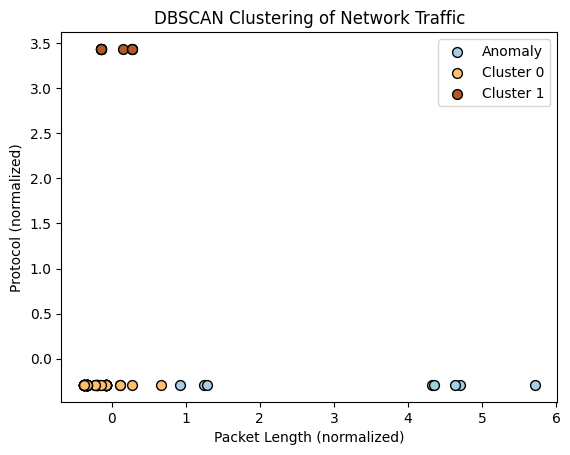

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot for clusters
unique_labels = np.unique(df['cluster'])
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_labels)))

# Plot each cluster
for k, col in zip(unique_labels, colors):
    class_member_mask = (df['cluster'] == k)
    xy = df[class_member_mask]
    plt.scatter(xy['len'], xy['ip_protocol'], c=[col], label=f'Cluster {k}' if k != -1 else 'Anomaly', edgecolor='k', s=50)

plt.xlabel('Packet Length (normalized)')
plt.ylabel('Protocol (normalized)')
plt.title('DBSCAN Clustering of Network Traffic')
plt.legend()
plt.show()


In [ ]:
# Display the anomalies
anomalies = df[df['cluster'] == -1]
anomalies

,time,src,dst,len,ip_protocol,cluster
frame_no,,,,,,
100,"Jun 1, 2024 08:52:16.074770230 EDT",4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,4.704558,-0.291111,-1
102,"Jun 1, 2024 08:52:16.180979364 EDT",9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,1.240533,-0.291111,-1
106,"Jun 1, 2024 08:52:16.183385913 EDT",4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,0.920072,-0.291111,-1
108,"Jun 1, 2024 08:52:16.269448314 EDT",9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,4.330688,-0.291111,-1
118,"Jun 1, 2024 08:52:16.392579039 EDT",4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,4.635888,-0.291111,-1
120,"Jun 1, 2024 08:52:16.504432365 EDT",9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,1.286313,-0.291111,-1
123,"Jun 1, 2024 08:52:16.506342945 EDT",4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,4.353578,-0.291111,-1
126,"Jun 1, 2024 08:52:16.843783832 EDT",9e52a5fa3e63ca2801379bee32ec2b6f3c7d0494072d2c...,4b7280351cfd0832818b9d509294cecf67f6c5bf57388b...,5.711720,-0.291111,-1


In [ ]:
anomalies.to_csv('anomalies.csv', index=False)